# Avaliando o impacto de uma política pública: Randomização e Variáveis Instrumentais

## Programa de Subsídios a Planos de Saúde (*Health Insurance Subsidy Program - HISP*)

Objetivo primário do programa: reduzir a despesa com itens relacionados a saúde para domicílios de baixa renda.

Variável de interesse: *health_expenditures*

----

## Leitura dos Dados

In [25]:
## Atualizando scipy
from IPython.display import clear_output # limpa o output de uma célula
!pip uninstall scipy -y
!pip install scipy

clear_output()  # limpando o texto

In [26]:
## Já instalando bibliotecas necessárias
!pip install linearmodels

clear_output()  # limpando o texto

In [27]:
## Importando o que for necessário
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import matplotlib as mpl
from linearmodels.iv import IV2SLS

In [28]:
## Módulos de teste
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan, linear_reset
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from patsy import dmatrices

In [29]:
## Montando o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
## Lendo os dados
sCaminho = "/content/drive/Othercomputers/Meu modelo MacBook Air/Documents/IPEA/Curso IDP/Avaliação de Impacto de Políticas - World Bank/Dados/"
sArquivo = "evaluation.dta"

## Lendo o DataFrame
df = pd.read_stata(f"{sCaminho}{sArquivo}")

# Vendo o tamanho da base
print(f"Linhas: {df.shape[0]}; Colunas: {df.shape[1]}")

Linhas: 19827; Colunas: 22


In [ ]:
## Vendo a descrição das variáveis (só funciona com arquivos .dta)
# Lendo novamente a base, mas agora com iterator, o que retorna um objeto do tipo StataReader
stata_reader = pd.read_stata(f"{sCaminho}{sArquivo}", iterator=True)

# Pegando as descrições das variáveis
descricoes = stata_reader.variable_labels()
descricoes

{'age_hh': 'Age of the head of the household (in years)',
 'age_sp': 'Age of the spouse (in years)',
 'bathroom': 'Home with private bathroom at baseline (0=no, 1=yes)',
 'dirtfloor': 'Home has a dirt floor at baseline (0=no, 1=yes)',
 'educ_hh': 'Education of the head of household (completed years of schooling)',
 'educ_sp': 'Education of the spouse (completed years of schooling)',
 'eligible': 'Household eligible to enroll in HISP (0=no, 1=yes)',
 'enrolled': 'HH enrolled in HISP (0=no, 1=yes)',
 'enrolled_rp': 'Household enrolled in HISP under the random promotion scenario (0=no, 1=yes)',
 'female_hh': 'Head of the household is a woman (0=no, 1=yes)',
 'health_expenditures': 'Out of pocket health expenditures (per person per year)',
 'hhsize': 'Number of household members (baseline)',
 'hospital': 'HH member visited hospital in the past year (0=no, 1=yes)',
 'hospital_distance': 'Distance to closest hospital',
 'household_identifier': 'Unique household identifier',
 'indigenous': 'H

In [ ]:
## Vendo o DataFrame
df.head(10)

,locality_identifier,household_identifier,treatment_locality,promotion_locality,eligible,enrolled,enrolled_rp,poverty_index,round,health_expenditures,age_hh,age_sp,educ_hh,educ_sp,female_hh,indigenous,hhsize,dirtfloor,bathroom,land,hospital_distance,hospital
0,26.0,5.0,1.0,1.0,1.0,1.0,1.0,55.950542,0.0,15.185455,24.0,23.0,0.0,6.0,0.0,0.0,4.0,1,0,1,124.819966,0.0
1,26.0,5.0,1.0,1.0,1.0,1.0,1.0,55.950542,1.0,19.580902,25.0,24.0,0.0,6.0,0.0,0.0,4.0,1,0,1,124.819966,0.0
2,26.0,11.0,1.0,1.0,1.0,1.0,0.0,46.058731,0.0,13.076257,30.0,26.0,4.0,0.0,0.0,0.0,6.0,1,0,2,124.819966,0.0
3,26.0,11.0,1.0,1.0,1.0,1.0,0.0,46.058731,1.0,2.398854,31.0,27.0,4.0,0.0,0.0,0.0,6.0,1,0,2,124.819966,1.0
4,26.0,13.0,1.0,1.0,1.0,1.0,0.0,54.095825,1.0,0.000000,59.0,57.0,0.0,0.0,0.0,0.0,6.0,1,0,4,124.819966,1.0
5,26.0,13.0,1.0,1.0,1.0,1.0,0.0,54.095825,0.0,15.286353,58.0,56.0,0.0,0.0,0.0,0.0,6.0,1,0,4,124.819966,0.0
6,26.0,16.0,1.0,1.0,1.0,1.0,1.0,56.903400,1.0,20.026909,36.0,25.0,3.0,0.0,0.0,0.0,7.0,1,0,2,124.819966,0.0
7,26.0,16.0,1.0,1.0,1.0,1.0,1.0,56.903400,0.0,11.311761,35.0,24.0,3.0,0.0,0.0,0.0,7.0,1,0,2,124.819966,0.0
8,26.0,21.0,1.0,1.0,1.0,1.0,1.0,46.908810,0.0,11.223912,37.0,35.0,0.0,0.0,0.0,0.0,7.0,1,0,2,124.819966,0.0
9,26.0,21.0,1.0,1.0,1.0,1.0,1.0,46.908810,1.0,16.664686,39.0,36.0,0.0,0.0,0.0,0.0,7.0,1,0,2,124.819966,0.0


In [ ]:
## Descrevendo o DataFrame
df.describe()

,locality_identifier,household_identifier,treatment_locality,promotion_locality,eligible,enrolled,enrolled_rp,poverty_index,round,health_expenditures,age_hh,age_sp,educ_hh,educ_sp,female_hh,indigenous,hhsize,dirtfloor,bathroom,land,hospital_distance,hospital
count,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,11257.000000
mean,73.933472,8038.965820,0.500277,0.512685,0.567761,0.299037,0.293287,56.789505,0.500025,17.035103,46.683117,40.581734,2.833550,2.618601,0.099057,0.352903,5.178645,0.603621,0.615978,2.079740,105.322517,0.052323
std,55.076599,4569.468262,0.500017,0.499851,0.495377,0.457822,0.455238,10.686106,0.500013,9.291589,15.294811,12.822810,2.754772,2.543370,0.298730,0.477869,2.195178,0.489157,0.486375,3.133202,42.063479,0.222696
min,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.479134,0.000000,0.000000,14.000000,14.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,9.465392,0.000000
25%,30.000000,3989.500000,0.000000,0.000000,0.000000,0.000000,0.000000,49.652241,0.000000,11.621977,34.000000,31.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,72.804218,0.000000
50%,59.000000,8040.000000,1.000000,1.000000,1.000000,0.000000,0.000000,56.414219,1.000000,16.051678,45.000000,41.000000,2.000000,2.000000,0.000000,0.000000,5.000000,1.000000,1.000000,1.000000,113.556497,0.000000
75%,112.000000,12033.000000,1.000000,1.000000,1.000000,1.000000,1.000000,62.905720,1.000000,21.236842,58.000000,48.000000,4.000000,4.000000,0.000000,1.000000,7.000000,1.000000,1.000000,3.000000,141.097735,0.000000
max,200.000000,15778.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000,1.000000,116.830643,88.000000,88.000000,16.000000,17.000000,1.000000,1.000000,13.000000,1.000000,1.000000,23.000000,170.457647,1.000000


In [ ]:
## Vendo média por período
df.groupby('round')['health_expenditures'].mean()

round
0.0    17.210985
1.0    16.859217
Name: health_expenditures, dtype: float32

In [ ]:
## Criando lista e fórmula com controles
# Lista
lControles = ["age_hh", "age_sp", "educ_hh", "educ_sp", "female_hh", "indigenous",
              "hhsize", "dirtfloor", "bathroom", "land", "hospital_distance"]

# Formulas
sControles = "age_hh + age_sp + educ_hh + educ_sp + female_hh + indigenous + hhsize + dirtfloor + bathroom + land + hospital_distance"

## Randomização

Para evitar problemas de transbordamento e cumprimento parcial, o HISP foi feito em comunidades inteiras (*treatment_locality* == 1).

Para verificar se a seleção foi aleatória, precisamos ver se as características de ambos os grupos (tratadas ou não) são iguais.

In [ ]:
## Pegando apenas os elegíveis (não necessariamente que participaram!)
dfElegiveis = df.query('eligible == 1')
dfElegiveis.shape

(11257, 22)

In [ ]:
## Vendo porcentagem de elegíveis
dfElegiveis.shape[0] / df.shape[0] 

0.5677611338074343

In [ ]:
## Testando, no nível base (período 0), as médias de CADA LOCALIDADE
# 'treatment_locality': 'Household is located in treatment community (0=no, 1=yes)'}

## Criando os DataFrames
dfTratamento = dfElegiveis.query('treatment_locality == 1 & round == 0')
dfComparacao = dfElegiveis.query('treatment_locality == 0 & round == 0')

for sVariavel in lControles:
  # Fazendo o teste
  tuplaTeste = stats.ttest_ind(dfTratamento[sVariavel], 
                               dfComparacao[sVariavel], 
                               nan_policy='omit', alternative='two-sided')
  
  ## Vendo se a diferença é significante
  sAsterisco = "**" if tuplaTeste[1] < 0.05 else ""

  # Printando ([0]=estatística; [1]=p-valor)
  print(f"\n========================= {sVariavel}{sAsterisco} =========================")
  print(f"Média Tratamento: {np.around(dfTratamento[sVariavel].mean(), 2)} \t Média Comparação: {np.around(dfComparacao[sVariavel].mean(), 2)}")
  print(f"Diferença = {np.around(dfTratamento[sVariavel].mean() - dfComparacao[sVariavel].mean(), 2)}")
  print(f"Estatística = {np.around(tuplaTeste[0], 4)} \t P-valor = {np.around(tuplaTeste[1], 4)}")


========================= age_hh =========================
Média Tratamento: 41.66 	 Média Comparação: 42.29
Diferença = -0.64
Estatística = -1.6948 	 P-valor = 0.0902

========================= age_sp =========================
Média Tratamento: 36.84 	 Média Comparação: 36.88
Diferença = -0.04
Estatística = -0.1238 	 P-valor = 0.9015

========================= educ_hh** =========================
Média Tratamento: 2.97 	 Média Comparação: 2.81
Diferença = 0.16
Estatística = 2.302 	 P-valor = 0.0214

========================= educ_sp =========================
Média Tratamento: 2.7 	 Média Comparação: 2.67
Diferença = 0.03
Estatística = 0.4321 	 P-valor = 0.6657

========================= female_hh =========================
Média Tratamento: 0.07 	 Média Comparação: 0.08
Diferença = -0.0
Estatística = -0.5846 	 P-valor = 0.5588

========================= indigenous =========================
Média Tratamento: 0.43 	 Média Comparação: 0.42
Diferença = 0.01
Estatística = 0.6898 	 P-valor =

In [ ]:
## E gastos com saúde?
sVariavel = "health_expenditures"

# Fazendo o teste
tuplaTeste = stats.ttest_ind(dfTratamento[sVariavel], 
                              dfComparacao[sVariavel], 
                              nan_policy='omit', alternative='two-sided')

## Vendo se a diferença é significante
sAsterisco = "**" if tuplaTeste[1] < 0.05 else ""

# Printando ([0]=estatística; [1]=p-valor)
print(f"========================= {sVariavel}{sAsterisco} =========================")
print(f"Média Tratamento: {np.around(dfTratamento[sVariavel].mean(), 2)} \t Média Comparação: {np.around(dfComparacao[sVariavel].mean(), 2)}")
print(f"Diferença = {np.around(dfTratamento[sVariavel].mean() - dfComparacao[sVariavel].mean(), 2)}")
print(f"Estatística = {np.around(tuplaTeste[0], 4)} \t P-valor = {np.around(tuplaTeste[1], 4)}")

========================= health_expenditures =========================
Média Tratamento: 14.49 	 Média Comparação: 14.57
Diferença = -0.08
Estatística = -0.7329 	 P-valor = 0.4637


Com exceção de duas variáveis, os locais tratados e os não-tratados não possuem diferenças estatisticamente signficantes, o que mostra que a seleção das localidades parece ter acontecidoo de forma randômica.

In [ ]:
## Fazendo regressões
# Elegíveis no round 0 (mesmos resultados do teste anterior)
formula_simples = "health_expenditures ~ 1 + treatment_locality"

# Fittando com covariância CLUSTERIZADA
# Porque? domicílios em uma mesma localidade podem ter correlação entre si
modelo_simples_antes = ols(formula_simples, dfElegiveis.query('round == 0')).fit(
    use_t=True, 
    cov_type='cluster', 
    cov_kwds={'groups': dfElegiveis.query('round == 0')["locality_identifier"]}
)

print(modelo_simples_antes.summary())

# R2, estatística F ruins: realmente domicílios antes eram semelhantes

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.000
Model:                             OLS   Adj. R-squared:                 -0.000
Method:                  Least Squares   F-statistic:                    0.1559
Date:                 Thu, 04 Nov 2021   Prob (F-statistic):              0.693
Time:                         23:49:56   Log-Likelihood:                -16195.
No. Observations:                 5628   AIC:                         3.239e+04
Df Residuals:                     5626   BIC:                         3.241e+04
Df Model:                            1                                         
Covariance Type:               cluster                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             14.5

In [ ]:
## Vendo quantidade de localidades (clusters)
dfElegiveis.query('round == 0')['locality_identifier'].nunique()

197

In [ ]:
# Elegíveis no round 1
modelo_simples_depois = ols(formula_simples, dfElegiveis.query('round == 1')).fit(
    use_t=True, 
    cov_type='cluster', 
    cov_kwds={'groups': dfElegiveis.query('round == 1')["locality_identifier"]}
)

print(modelo_simples_depois.summary())

## Localidades diferentes após o programa passam a ter grandes diferenças!
# (ver R2, Prob(F) e magnitude de treatment_locality)

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.300
Model:                             OLS   Adj. R-squared:                  0.300
Method:                  Least Squares   F-statistic:                     656.8
Date:                 Thu, 04 Nov 2021   Prob (F-statistic):           1.70e-64
Time:                         23:49:56   Log-Likelihood:                -19497.
No. Observations:                 5629   AIC:                         3.900e+04
Df Residuals:                     5627   BIC:                         3.901e+04
Df Model:                            1                                         
Covariance Type:               cluster                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             17.9

In [ ]:
## E com uma regressão múltipla?
# Formula
formula_multipla = f"{formula_simples} + {sControles}"

modelo_multiplo_depois = ols(formula_multipla, dfElegiveis.query('round == 1')).fit(
    use_t=True, 
    cov_type='cluster', 
    cov_kwds={'groups': dfElegiveis.query('round == 1')["locality_identifier"]}
)

print(modelo_multiplo_depois.summary())

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.430
Model:                             OLS   Adj. R-squared:                  0.428
Method:                  Least Squares   F-statistic:                     136.0
Date:                 Thu, 04 Nov 2021   Prob (F-statistic):           4.78e-88
Time:                         23:49:56   Log-Likelihood:                -18922.
No. Observations:                 5629   AIC:                         3.787e+04
Df Residuals:                     5616   BIC:                         3.796e+04
Df Model:                           12                                         
Covariance Type:               cluster                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             27.5

**PERGUNTA**: por que os resultados de *treatment_locality* são tão parecidos?

Dica: lembre-se que a seleção das localidades se deu de forma *aleatória*. Se estiver com dúvida, veja a página 94 da referência principal (em português)!

## Variável Instrumental (VI) - Capítulo 5 

#### Vale a pena dar uma lida!

Nesse método, todos são elegíveis para o programa. Assim, devemos comparar o que acontece nas vilas que tiveram a promoção do programa com aquelas que não receberam nenhuma promoção.

Nesse contexto de Avaliação, as VIs servem para solucionar o problema do **cumprimento parcial**, no qual nem todos os selecionados para o tratamento efetivamente participam e alguns não selecionandos acabam entrando na política.

Além disso, pode-se usar a **promoção aleatória**, em que, ao invés de selecionar, estaremos **promovendo aleatoriamente** o programa, o qual passa a ter inscrição aberta para toda a população elegível.
Desde que as pessoas do grupo "Participa se for encorajado" sejam numerosas o suficiente, conseguimos estimar o LATE.

### Promoção Aleatória

Supondo que o Ministério da Saúde ordene que o HISP seja aberto a todos os domicílios que queiram se inscrever, ou seja, não é mais possível selecionar aleatoriamente os participantes; o que podemos fazer, contudo, é criar um esquema de promoção aleatória para medir o efeito do tratamento APENAS no grupo "Participa se for encorajado" (que não pode ser extrapolado para os "Sempre" ou "Nunca" por possuírem características diferentes do grupo que é efetivamente afetado pela promoção).

In [ ]:
## Verificando que as variáveis são iguais para as vilas promovidas e aquelas que não foram
#  'promotion_locality': 'Household is located in promoted community (0=no, 1=yes)',
## Criando os DataFrames
dfPromovido = df.query('promotion_locality == 1 & round == 0')
dfComparacao = df.query('promotion_locality == 0 & round == 0')

for sVariavel in lControles:
  # Fazendo o teste
  tuplaTeste = stats.ttest_ind(dfPromovido[sVariavel], 
                               dfComparacao[sVariavel], 
                               nan_policy='omit', alternative='two-sided')
  
  ## Vendo se a diferença é significante
  sAsterisco = "**" if tuplaTeste[1] < 0.05 else ""

  # Printando ([0]=estatística; [1]=p-valor)
  print(f"\n========================= {sVariavel}{sAsterisco} =========================")
  print(f"Média Promoção: {np.around(dfPromovido[sVariavel].mean(), 2)} \t Média Comparação: {np.around(dfComparacao[sVariavel].mean(), 2)}")
  print(f"Diferença = {np.around(dfPromovido[sVariavel].mean() - dfComparacao[sVariavel].mean(), 2)}")
  print(f"Estatística = {np.around(tuplaTeste[0], 4)} \t P-valor = {np.around(tuplaTeste[1], 4)}")

## As características entre as vilas promovidas ou não parecem ser diferentes!


========================= age_hh** =========================
Média Promoção: 45.79 	 Média Comparação: 46.63
Diferença = -0.84
Estatística = -2.7262 	 P-valor = 0.0064

========================= age_sp** =========================
Média Promoção: 39.79 	 Média Comparação: 40.6
Diferença = -0.8
Estatística = -3.1324 	 P-valor = 0.0017

========================= educ_hh** =========================
Média Promoção: 2.77 	 Média Comparação: 2.9
Diferença = -0.14
Estatística = -2.4669 	 P-valor = 0.0136

========================= educ_sp** =========================
Média Promoção: 2.56 	 Média Comparação: 2.68
Diferença = -0.12
Estatística = -2.3038 	 P-valor = 0.0213

========================= female_hh =========================
Média Promoção: 0.1 	 Média Comparação: 0.1
Diferença = 0.0
Estatística = 0.0382 	 P-valor = 0.9695

========================= indigenous** =========================
Média Promoção: 0.32 	 Média Comparação: 0.39
Diferença = -0.07
Estatística = -7.6871 	 P-valor = 0.

In [ ]:
## E gastos com saúde?
sVariavel = "health_expenditures"
# Fazendo o teste
tuplaTeste = stats.ttest_ind(dfPromovido[sVariavel], 
                              dfComparacao[sVariavel], 
                              nan_policy='omit', alternative='two-sided')

## Vendo se a diferença é significante
sAsterisco = "**" if tuplaTeste[1] < 0.05 else ""

# Printando ([0]=estatística; [1]=p-valor)
print(f"========================= {sVariavel}{sAsterisco} =========================")
print(f"Média Promoção: {np.around(dfPromovido[sVariavel].mean(), 4)} \t Média Comparação: {np.around(dfComparacao[sVariavel].mean(), 4)}")
print(f"Diferença = {np.around(dfPromovido[sVariavel].mean() - dfComparacao[sVariavel].mean(), 4)}")
print(f"Estatística = {np.around(tuplaTeste[0], 4)} \t P-valor = {np.around(tuplaTeste[1], 4)}")

## Apesar de as características serem diferentes, os gastos com saúde são similares

========================= health_expenditures =========================
Média Promoção: 17.1853 	 Média Comparação: 17.238
Diferença = -0.0526
Estatística = -0.4684 	 P-valor = 0.6395


In [ ]:
## A mesma coisa pode ser feita com uma regressão:
formula_base = "health_expenditures ~ 1 + promotion_locality"
modelo_base = ols(data=df.query('round == 0'), formula=formula_base).fit(cov_type='HC2')
print(modelo_base.summary())

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.000
Model:                             OLS   Adj. R-squared:                 -0.000
Method:                  Least Squares   F-statistic:                    0.2191
Date:                 Thu, 04 Nov 2021   Prob (F-statistic):              0.640
Time:                         23:49:57   Log-Likelihood:                -31122.
No. Observations:                 9913   AIC:                         6.225e+04
Df Residuals:                     9911   BIC:                         6.226e+04
Df Model:                            1                                         
Covariance Type:                   HC2                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             17.2

In [ ]:
## E a participação efetiva (com promoção aleatória)?
sVariavel = "enrolled_rp"
# Fazendo o teste
tuplaTeste = stats.ttest_ind(dfPromovido[sVariavel], 
                              dfComparacao[sVariavel], 
                              nan_policy='omit', alternative='two-sided')

## Vendo se a diferença é significante
sAsterisco = "**" if tuplaTeste[1] < 0.05 else ""

# Printando ([0]=estatística; [1]=p-valor)
print(f"========================= {sVariavel}{sAsterisco} =========================")
print(f"Média Promoção: {np.around(dfPromovido[sVariavel].mean(), 3)} \t Média Comparação: {np.around(dfComparacao[sVariavel].mean(), 3)}")
print(f"Diferença = {np.around(dfPromovido[sVariavel].mean() - dfComparacao[sVariavel].mean(), 3)}")
print(f"Estatística = {np.around(tuplaTeste[0], 4)} \t P-valor = {np.around(tuplaTeste[1], 4)}")

nParticipaEncorojado = dfPromovido[sVariavel].mean() - dfComparacao[sVariavel].mean()

## A promoção foi muito boa em incentivar a adesão ao HISP, com uma diferença de 40,8%

========================= enrolled_rp** =========================
Média Promoção: 0.492 	 Média Comparação: 0.084
Diferença = 0.408
Estatística = 49.8326 	 P-valor = 0.0


In [ ]:
## Podemos ver também a diferença nos gastos com saúde das vilas promocionadas APÓS o HISP
## Criando os DataFrames
dfPromovido1 = df.query('promotion_locality == 1 & round == 1')
dfComparacao1 = df.query('promotion_locality == 0 & round == 1')

sVariavel = "health_expenditures"
# Fazendo o teste
tuplaTeste = stats.ttest_ind(dfPromovido1[sVariavel], 
                              dfComparacao1[sVariavel], 
                              nan_policy='omit', alternative='two-sided')

## Vendo se a diferença é significante
sAsterisco = "**" if tuplaTeste[1] < 0.05 else ""

# Printando ([0]=estatística; [1]=p-valor)
print(f"========================= {sVariavel}{sAsterisco} =========================")
print(f"Média Promoção: {np.around(dfPromovido1[sVariavel].mean(), 4)} \t Média Comparação: {np.around(dfComparacao1[sVariavel].mean(), 4)}")
print(f"Diferença = {np.around(dfPromovido1[sVariavel].mean() - dfComparacao1[sVariavel].mean(), 4)}")
print(f"Estatística = {np.around(tuplaTeste[0], 4)} \t P-valor = {np.around(tuplaTeste[1], 4)}")


========================= health_expenditures** =========================
Média Promoção: 14.9715 	 Média Comparação: 18.8454
Diferença = -3.8738
Estatística = -16.433 	 P-valor = 0.0


Os resultados indicam que houve uma queda nos gastos com saúde nas vilas promocionadas =D.

Contudo, sabemos que isso se deve majoritariamente ao grupo que "participa se incentivado", que compõe cerca de 40,8% da população (Sempre=8,4%; Nunca=Resto).

In [ ]:
## Podemos ter uma primeira estimativa do LATE dividindo a diferença anterior 
## pela % da população no grupo "Participa se encorajado"
nDiferencaPromocao = (dfPromovido1[sVariavel].mean() - dfComparacao1[sVariavel].mean()) / nParticipaEncorojado
nDiferencaPromocao

# Nossa primeira estimativa é que o programa conseguiu reduzir em US$ 9,5 (por pessoa por ano)
# nos gastos com saúde do grupo de Participa se for Encorajado

# Reforçando: o resultado NÃO pode ser extrapolado para os demais!!!

-9.502065361089176

### MQ2E

De forma mais formal e acurada, podemos calcular o impacto acima usando variáveis instrumentais e MQ2E.

#### "Na mão"

Para vermos na prática O QUE uma VI faz, podemos estimá-la manualmente (em modelos mais simples).

Vamos assumir que a promoção é uma variável instrumental da participação no programa (enrolled_rp).

In [ ]:
## Fazendo o modelo inicial
# Filtrando os dados
dfRound0 = df.query('round == 0')
dfRound1 = df.query('round == 1')

# Modelo
formula_vi_primeiro_estagio = "enrolled_rp ~ 1 + promotion_locality"

modelo_vi_primeiro_estagio = IV2SLS.from_formula(formula=formula_vi_primeiro_estagio,
                                                 data=dfRound1).fit()
print(modelo_vi_primeiro_estagio.summary)

                            OLS Estimation Summary                            
Dep. Variable:            enrolled_rp   R-squared:                      0.2004
Estimator:                        OLS   Adj. R-squared:                 0.2003
No. Observations:                9914   F-statistic:                    2552.8
Date:                Fri, Nov 05 2021   P-value (F-stat)                0.0000
Time:                        00:14:41   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                                 Parameter Estimates                                  
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
Intercept              0.0842     0.0040     21.082     0.0000      0.0764      0.0921
promotion_locality  

In [ ]:
## Pegando os valores fittados e adicionando
dfRound1['enrolled_rp_vi'] = modelo_vi_primeiro_estagio.fitted_values
dfRound1['enrolled_rp_vi']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1        0.492032
3        0.492032
4        0.492032
6        0.492032
9        0.492032
           ...   
19817    0.084248
19819    0.084248
19821    0.084248
19824    0.492032
19826    0.492032
Name: enrolled_rp_vi, Length: 9914, dtype: float64

In [ ]:
## Usando esses valores pra fittar o novo modelo
formula_vi_segundo_estagio = "health_expenditures ~ 1 + enrolled_rp_vi"

modelo_vi_segundo_estagio = IV2SLS.from_formula(formula=formula_vi_segundo_estagio,
                                                 data=dfRound1).fit()
print(modelo_vi_segundo_estagio.summary)

# US$ -9,49, assim como vimos na análise de médias!

                             OLS Estimation Summary                            
Dep. Variable:     health_expenditures   R-squared:                      0.0265
Estimator:                         OLS   Adj. R-squared:                 0.0264
No. Observations:                 9914   F-statistic:                    272.09
Date:                 Fri, Nov 05 2021   P-value (F-stat)                0.0000
Time:                         00:17:09   Distribution:                  chi2(1)
Cov. Estimator:                 robust                                         
                                                                               
                               Parameter Estimates                                
                Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------
Intercept          19.646     0.1915     102.60     0.0000      19.270      20.021
enrolled_rp_vi    -9.4998   

In [ ]:
## Criando o modelo diretamente
formula_vi_simples = "health_expenditures ~ 1 + [enrolled_rp ~ promotion_locality]"

modelo_vi_simples = IV2SLS.from_formula(formula=formula_vi_simples,
                                                 data=dfRound1).fit()
print(modelo_vi_simples.summary)

# A única coisa que muda é o erro-padrão (ao fazer na mão, deixamos 
# alguns detalhes estatísticos de lado, o que também faz com que o R2 e F
# estejam errados)

# Outro detalhe: por padrão, a estimativa de VI já é com erros-padrão robustos

                           IV-2SLS Estimation Summary                          
Dep. Variable:     health_expenditures   R-squared:                      0.2217
Estimator:                     IV-2SLS   Adj. R-squared:                 0.2216
No. Observations:                 9914   F-statistic:                    338.60
Date:                 Fri, Nov 05 2021   P-value (F-stat)                0.0000
Time:                         00:18:34   Distribution:                  chi2(1)
Cov. Estimator:                 robust                                         
                                                                               
                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
Intercept       19.646     0.1806     108.76     0.0000      19.292      20.000
enrolled_rp    -9.4998     0.5163    -18

In [ ]:
## Podemos também ver os resultados de 1º estágio
print(modelo_vi_simples.first_stage)

    First Stage Estimation Results    
                           enrolled_rp
--------------------------------------
R-squared                       0.2004
Partial R-squared               0.2004
Shea's R-squared                0.2004
Partial F-statistic             2552.8
P-value (Partial F-stat)        0.0000
Partial F-stat Distn           chi2(1)
==========================  ==========
Intercept                       0.0842
                              (21.082)
promotion_locality              0.4078
                              (50.525)
--------------------------------------

T-stats reported in parentheses
T-stats use same covariance type as original model


Como temos apenas um instrumento, não podemos testar sua exogeneidade usando um teste de restrições sobreidentificadoras, mas sabemos que *promotion_locality* é relevante (e provavelmente exógeno, dado que é uma variável aleatóoria).

In [ ]:
## Num modelo sem VI, os efeitos do programa seriam viesados para cima 
# (uma vez que a seleção/participação no programa não é mais a aleatória)
formula_simples = "health_expenditures ~ 1 + enrolled_rp"

modelo_simples = ols(formula=formula_simples, data=dfRound1).fit()
print(modelo_simples.summary())

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.237
Model:                             OLS   Adj. R-squared:                  0.237
Method:                  Least Squares   F-statistic:                     3076.
Date:                 Fri, 05 Nov 2021   Prob (F-statistic):               0.00
Time:                         00:21:44   Log-Likelihood:                -37272.
No. Observations:                 9914   AIC:                         7.455e+04
Df Residuals:                     9912   BIC:                         7.456e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      20.5869      0.124    165

In [ ]:
## Fazendo um modelo mais completo e com covariâancia clusterizada
formula_vi = f"{formula_vi_simples} + {sControles}"

modelo_vi = IV2SLS.from_formula(formula=formula_vi, data=dfRound1).fit(
  cov_type='clustered',  # note o -ED no final
  clusters=dfRound1["locality_identifier"]
)
print(modelo_vi.summary)

## Efeito mais preciso: -9.74 (dólares por pessoa por ano); note que o efeito muda
## mais em virtude do fato de as vilas promovidas serem um pouco distintas em suas
## características observáveis daquelas que não foram promovidas.

                           IV-2SLS Estimation Summary                          
Dep. Variable:     health_expenditures   R-squared:                      0.4057
Estimator:                     IV-2SLS   Adj. R-squared:                 0.4049
No. Observations:                 9914   F-statistic:                    2414.3
Date:                 Fri, Nov 05 2021   P-value (F-stat)                0.0000
Time:                         00:24:22   Distribution:                 chi2(12)
Cov. Estimator:              clustered                                         
                                                                               
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             29.168     0.8355     34.912     0.0000      27.531      30.806
age_hh          

-----

## Resolução do Exercício - Aula de 04/11/2021

----

### 1) Randomização

#### a) Usando o dataset “evaluation.dta”, filtre a base apenas para as pessoas elegíveis para o programa em round == 1.

In [31]:
## Lendo os dados
sCaminho = "/content/drive/Othercomputers/Meu modelo MacBook Air/Documents/IPEA/Curso IDP/Avaliação de Impacto de Políticas - World Bank/Dados/"
sArquivo = "evaluation.dta"

## Lendo o DataFrame
df = pd.read_stata(f"{sCaminho}{sArquivo}")

# Vendo o tamanho da base
print(f"Linhas: {df.shape[0]}; Colunas: {df.shape[1]}")

Linhas: 19827; Colunas: 22


In [32]:
## Criando lista e fórmula com controles
# Lista
lControles = ["age_hh", "age_sp", "educ_hh", "educ_sp", "female_hh", "indigenous",
              "hhsize", "dirtfloor", "bathroom", "land", "hospital_distance"]

# Formulas
sControles = "age_hh + age_sp + educ_hh + educ_sp + female_hh + indigenous + hhsize + dirtfloor + bathroom + land + hospital_distance"

In [33]:
## Pegando apenas os elegíveis (não necessariamente que participaram!)
dfElegiveis1 = df.query('eligible == 1 & round == 1')
dfElegiveis1.shape

(5629, 22)

#### b) Regrida health_expenditures sobre treatment_locality e printe o sumário. Qual o efeito de treatment_locality sobre as despesas com saúde?

In [34]:
## Modelo de regressão
# Fórmula
formula_simples = "health_expenditures ~ 1 + treatment_locality"

# Modelo
modelo_simples_depois = ols(formula_simples, dfElegiveis1).fit(
    use_t=True, 
    cov_type='cluster', 
    cov_kwds={'groups': dfElegiveis1["locality_identifier"]}
)

print(modelo_simples_depois.summary())

## Localidades diferentes após o programa passam a ter grandes diferenças!
# (ver R2, Prob(F) e magnitude de treatment_locality)

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.300
Model:                             OLS   Adj. R-squared:                  0.300
Method:                  Least Squares   F-statistic:                     656.8
Date:                 Wed, 10 Nov 2021   Prob (F-statistic):           1.70e-64
Time:                         00:11:30   Log-Likelihood:                -19497.
No. Observations:                 5629   AIC:                         3.900e+04
Df Residuals:                     5627   BIC:                         3.901e+04
Df Model:                            1                                         
Covariance Type:               cluster                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             17.9

#### c) Regrida health_expenditures sobre o set completo de variáveis de controle (definido no notebook da aula). Qual o efeito de treatment_locality sobre as despesas com saúde?

In [35]:
## Regressão Múltipla
# Formula
formula_multipla = f"{formula_simples} + {sControles}"

# modelo
modelo_multiplo_depois = ols(formula_multipla, dfElegiveis1).fit(
    use_t=True, 
    cov_type='cluster', 
    cov_kwds={'groups': dfElegiveis1["locality_identifier"]}
)

print(modelo_multiplo_depois.summary())

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.430
Model:                             OLS   Adj. R-squared:                  0.428
Method:                  Least Squares   F-statistic:                     136.0
Date:                 Wed, 10 Nov 2021   Prob (F-statistic):           4.78e-88
Time:                         00:11:57   Log-Likelihood:                -18922.
No. Observations:                 5629   AIC:                         3.787e+04
Df Residuals:                     5616   BIC:                         3.796e+04
Df Model:                           12                                         
Covariance Type:               cluster                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             27.5

#### d) Por que os resultados dos itens b) e c) são tão parecidos? Lembre-se de que a seleção das localidades se deu de forma aleatória!

In [36]:
## Teoricamente, a randomização faz com que nenhuma das características seja correlacionada com o tratamento.
## Em outras palavras, pessoas tratadas não foram selecionadas porque eram mais pobres, mais educadas...

## Criando a lista com os controles e a variável que indica se a pessoa está em uma localidade de tratamento
lista = lControles.copy()  # usamos o copy para não ocupar o mesmo espaço de memória

## Adicionando treatment_locality
lista.append("treatment_locality")

In [37]:
## Vendo a correlação
dfCorr = dfElegiveis1[lista].corr()
dfCorr

# A correlação de treatment_locality com todas as variáveis não excede 0.034, ou seja, é muito desprezível
# Assim, quando adicionarmos essas variáveis à regressão, a estimativa de treatment_locality NÃO se altera

# Lembrando dos testes, a multicolinearidade de treatment_locality é muito próxima de 0.

,age_hh,age_sp,educ_hh,educ_sp,female_hh,indigenous,hhsize,dirtfloor,bathroom,land,hospital_distance,treatment_locality
age_hh,1.000000,0.818038,-0.472455,-0.424434,0.205344,0.029585,0.038722,0.023615,0.031037,0.176376,0.054457,-0.022291
age_sp,0.818038,1.000000,-0.411652,-0.442804,0.079023,0.032386,0.084954,0.029310,0.045003,0.173708,0.057175,-0.003177
educ_hh,-0.472455,-0.411652,1.000000,0.479413,-0.163262,-0.022145,-0.009699,-0.086646,0.079452,-0.064399,0.024829,0.030316
educ_sp,-0.424434,-0.442804,0.479413,1.000000,-0.066668,-0.128577,-0.054645,-0.126747,0.041917,-0.074297,-0.002433,0.005927
female_hh,0.205344,0.079023,-0.163262,-0.066668,1.000000,0.005793,-0.137924,0.032091,-0.049828,-0.034429,-0.019836,-0.007841
indigenous,0.029585,0.032386,-0.022145,-0.128577,0.005793,1.000000,-0.096833,0.237695,0.083296,0.019947,0.309551,0.009390
hhsize,0.038722,0.084954,-0.009699,-0.054645,-0.137924,-0.096833,1.000000,-0.145908,0.123218,0.157737,-0.039252,0.015100
dirtfloor,0.023615,0.029310,-0.086646,-0.126747,0.032091,0.237695,-0.145908,1.000000,-0.076913,-0.026808,0.093981,-0.014797
bathroom,0.031037,0.045003,0.079452,0.041917,-0.049828,0.083296,0.123218,-0.076913,1.000000,0.083371,0.112660,0.015248
land,0.176376,0.173708,-0.064399,-0.074297,-0.034429,0.019947,0.157737,-0.026808,0.083371,1.000000,0.057455,-0.007267


In [55]:
## Criando máscara para ocultar diagonal superior do mapa de calor
mask = np.zeros_like(dfCorr, dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)] = True

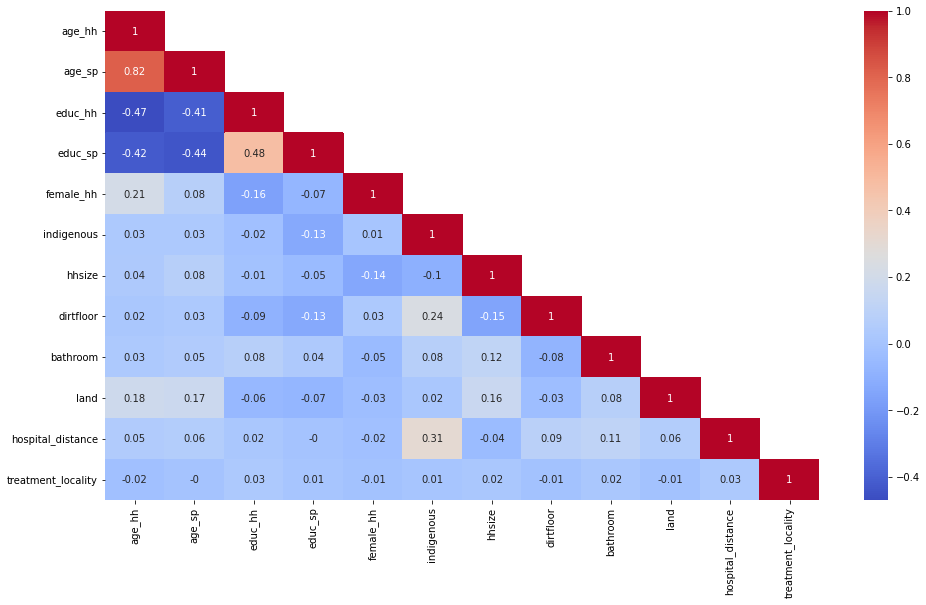

In [57]:
### Fazendo um mapa de calor!
## Importando seaborn
import seaborn as sns

## Fazendo a figura
# Objeto gráfico (aumentando o tamanho pra caber direitinho)
fig, ax = plt.subplots(figsize = (16,9))
# Criando o mapa de calor
# cmap: escalas de cor (coolwarm: azul->vermelho)
# annot: colocar os valores (não só pintar)
# linewidth: colocar linhas entre os quadrados e pintá-las de preto (linecolor)
# fmt = g: formatar como número normal (nada de científico)
sns.heatmap(round(dfCorr, 2), cmap='coolwarm', annot=True, fmt='g', mask=mask)

# Note as cores da última linha!

----

### 2) Variáveis Instrumentais

#### a) Filtre o dataset para conter apenas as observações em round == 1.

In [40]:
## Filtrando
dfRound1 = df.query('round == 1')

#### b) Adicionando variáveis apenas relacionados ao chefe do domicílio e ao cônjuge

Primeiro, vamos estimar os modelos mais simples e o modelo completo para ter a base de comparação.

In [41]:
## Modelo simples
formula_vi_simples = "health_expenditures ~ 1 + [enrolled_rp ~ promotion_locality]"

modelo_vi_simples = IV2SLS.from_formula(formula=formula_vi_simples, data=dfRound1).fit(
  cov_type='clustered',
  clusters=dfRound1["locality_identifier"]
)
print(modelo_vi_simples.summary)

                           IV-2SLS Estimation Summary                          
Dep. Variable:     health_expenditures   R-squared:                      0.2217
Estimator:                     IV-2SLS   Adj. R-squared:                 0.2216
No. Observations:                 9914   F-statistic:                    70.682
Date:                 Wed, Nov 10 2021   P-value (F-stat)                0.0000
Time:                         00:28:44   Distribution:                  chi2(1)
Cov. Estimator:              clustered                                         
                                                                               
                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
Intercept       19.646     0.4651     42.238     0.0000      18.734      20.557
enrolled_rp    -9.4998     1.1299    -8.

In [42]:
## Modelo completo
formula_vi = f"{formula_vi_simples} + {sControles}"

modelo_vi = IV2SLS.from_formula(formula=formula_vi, data=dfRound1).fit(
  cov_type='clustered',
  clusters=dfRound1["locality_identifier"]
)
print(modelo_vi.summary)

## Note a diferença de -0,24 entre as estimativas! Ele já muda um pouco mais que o coeficiente
## da seleção aleatória (+0,13), mas ainda relativamente pouco frente ao total

## Lembre: usamos a VI para simular uma seleção aleatória de participação
## no tratamento a partir da promoção aleatória

                           IV-2SLS Estimation Summary                          
Dep. Variable:     health_expenditures   R-squared:                      0.4057
Estimator:                     IV-2SLS   Adj. R-squared:                 0.4049
No. Observations:                 9914   F-statistic:                    2414.3
Date:                 Wed, Nov 10 2021   P-value (F-stat)                0.0000
Time:                         00:29:06   Distribution:                 chi2(12)
Cov. Estimator:              clustered                                         
                                                                               
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             29.168     0.8355     34.912     0.0000      27.531      30.806
age_hh          

In [43]:
## Modelo pedido na questão b)
formula_vi = f"{formula_vi_simples} + age_hh + age_sp + educ_hh + educ_sp + female_hh + indigenous"

modelo_vi = IV2SLS.from_formula(formula=formula_vi, data=dfRound1).fit(
  cov_type='clustered',
  clusters=dfRound1["locality_identifier"]
)
print(modelo_vi.summary)

## Valor vai para -US$ 9.65

                           IV-2SLS Estimation Summary                          
Dep. Variable:     health_expenditures   R-squared:                      0.2700
Estimator:                     IV-2SLS   Adj. R-squared:                 0.2695
No. Observations:                 9914   F-statistic:                    522.33
Date:                 Wed, Nov 10 2021   P-value (F-stat)                0.0000
Time:                         00:30:51   Distribution:                  chi2(7)
Cov. Estimator:              clustered                                         
                                                                               
                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
Intercept       13.701     0.8675     15.793     0.0000      12.000      15.401
age_hh          0.1402     0.0166     8.

In [44]:
## Modelo pedido na questão c)
formula_vi = f"{formula_vi_simples} + hhsize + dirtfloor + bathroom + land + hospital_distance"

modelo_vi = IV2SLS.from_formula(formula=formula_vi, data=dfRound1).fit(
  cov_type='clustered',
  clusters=dfRound1["locality_identifier"]
)
print(modelo_vi.summary)

## Valor cai (em módulo) para -US$ 9.42

                           IV-2SLS Estimation Summary                          
Dep. Variable:     health_expenditures   R-squared:                      0.3892
Estimator:                     IV-2SLS   Adj. R-squared:                 0.3888
No. Observations:                 9914   F-statistic:                    1884.9
Date:                 Wed, Nov 10 2021   P-value (F-stat)                0.0000
Time:                         00:31:20   Distribution:                  chi2(6)
Cov. Estimator:              clustered                                         
                                                                               
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             32.930     0.6184     53.249     0.0000      31.718      34.142
hhsize          

In [ ]:
## Em resumo: pela variação de enrolled_rp frente ao modelo simples, ela parece estar mais correlacionada com
## as variáveis do chefe do domicílio/conjuge; lembre-se que a seleção não é 100% aleatória!

## Essa não-aleatoriedade pura pode ser vista nos testes t feitos em sala de aula, em que se viu
## que a promoção aleatória é correlacionada com algumas das variáveis observáveis

# Contudo, as variações em ambos os casos são muito pequenas, de forma que podemos afirmar que
# a estimativa a partir da promoção aleatória não foi afetada de forma significativa. 